In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score, classification_report
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import ipywidgets as widgets
from IPython.display import display, clear_output
from pandas.io.formats import style
from IPython.display import display
from ipywidgets import Button, GridBox, Layout, ButtonStyle


%matplotlib inline

initial_df = pd.read_csv("insurance.csv")

# one hot encoding
df = pd.get_dummies(initial_df, drop_first=True)
# dodanie kategorii otyły (w USA wg jakiegoś medycznego instytu jest po prostu powyżej 30
df["obese"] = df["bmi"].apply(lambda x: 1 if x >= 30 else 0)
# dodanie kategorii otyły i palący
df["obese_smoker"] = df[["obese", "smoker_yes"]].apply(
    lambda x: 1 if (x["obese"] == 1) & (x["smoker_yes"] == 1) else 0, axis=1
)

In [2]:
initial_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [3]:
df.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest', 'obese',
       'obese_smoker'],
      dtype='object')

In [4]:
#widgets
style = {'description_width': 'initial'}

widget_sex = widgets.Select(
    options = sorted(initial_df['sex'].unique().tolist()),
    description = 'Sex',
    style = style,
    disabled = False,
    layout = {'width': 'max-content'})

widget_region = widgets.Select(
    options = sorted(initial_df['region'].unique().tolist()),
    description = 'Region',
    style = style,
    disabled = False,
    layout = {'width': 'max-content'})

widget_age = widgets.IntSlider(
    min = initial_df['age'].min(),
    max = 64,
    description = 'Age',
    style = style)

widget_height = widgets.IntSlider(
    min = 100,
    max = 220,
    description = 'Height [cm]',
    style = style)

widget_weight = widgets.FloatSlider(
    min = 35,
    max = 200,
    description = 'Weight [kg]',
    style = style)

widget_children = widgets.IntSlider(
    min = initial_df['children'].min(),
    max = 8,
    description = 'Children',
    style = style)

widget_smoker = widgets.RadioButtons(
    options=[('Yes',1), ('No',0)],
    style=style,
    disabled = False,
    description='Smoker')

# widget_smoker = widgets.Select(
#     options = ['Yes', 'No'],
#     description = 'Smoker',
#     style = style,
#     disabled = False,
#     layout = {'width': 'max-content'})

In [5]:
#widget handler

values = {'sex_dropdown': widget_sex.value,
          'region_dropdown': widget_region.value,
          'age_slider': widget_age.value,
          'height_slider': widget_height.value,
          'weight_slider': widget_weight.value,
          'children_slider': widget_children.value,
          'smoker_button': widget_smoker.value}
def widgets_handler(sex_dropdown_val,
                    region_dropdown_val,
                    smoker_button_val,
                    age_slider_val,
                    children_slider_val,
                    height_slider_val,
                    weight_slider_val):
    values['sex_dropdown'] = sex_dropdown_val
    values['region_dropdown'] = region_dropdown_val
    values['age_slider'] = age_slider_val
    values['height_slider'] = height_slider_val
    values['weight_slider'] = weight_slider_val
    values['children_slider'] = children_slider_val
    values['smoker_button'] = smoker_button_val

In [6]:
# filters = GridBox(children=[widget_sex, widget_region, widget_smoker, widget_age, 
#                             widget_height, widget_weight, widget_children,
#                             run_button],
#                     layout=Layout(
#                     width='100%',
#                     grid_template_columns='300px 300px 300px',
#                     grid_template_rows='auto auto auto',
#                     grid_gap='5px 10px')
#                )

In [7]:
# display(filters)

In [8]:
import pickle
# Load the Model back from file
Pkl_Ridge = 'pickled_ridge_model.pkl'  
Pkl_EN = 'pickled_en_model.pkl'  
Pkl_XGB = 'pickled_xgb_model.pkl'  
Pkl_Stacked = 'pickled_stacked_model.pkl'
Pkl_data='pickled_data'


with open(Pkl_Ridge, 'rb') as file1:  
    ridge_model = pickle.load(file1)

with open(Pkl_EN, 'rb') as file2:  
    en_model = pickle.load(file2)
    
with open(Pkl_XGB, 'rb') as file3:  
    xgb_model = pickle.load(file3)

with open(Pkl_Stacked, 'rb') as file4:  
    stacked_model = pickle.load(file4)
    
with open(Pkl_data, 'rb') as file4:  
    df = pickle.load(file4)


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,obese,obese_smoker
0,19,27.900,0,0,1,0,0,1,0,0
1,18,33.770,1,1,0,0,1,0,1,0
2,28,33.000,3,1,0,0,1,0,1,0
3,33,22.705,0,1,0,1,0,0,0,0
4,32,28.880,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,1,0,1,0,0,1,0
1334,18,31.920,0,0,0,0,0,0,1,0
1335,18,36.850,0,0,0,0,1,0,1,0
1336,21,25.800,0,0,0,0,0,1,0,0


In [10]:
ridge_model.score(X_test,y_test)

0.8712125654141842

In [11]:
en_model.score(X_test,y_test)

0.8711719305610985

In [12]:
xgb_model.score(X_test,y_test)

0.8730627049627262

In [13]:
# bardziej powtarzalny, lepszy wynik z CV
stacked_model.score(X_test,y_test)

0.8728794330786501

#### Ewaluacja modeli

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from math import sqrt

In [15]:
from sklearn import set_config
import time

In [16]:
def run_model(pipeline, Xtrain, ytrain, Xtest, ytest):
    set_config(display='diagram')
    pd.options.display.float_format = "{:,.2f}".format
    
    y_pred_train = pipeline.predict(Xtrain).reshape(-1,1)
    y_pred_test = pipeline.predict(Xtest).reshape(-1,1)
    pipeline_name = display(pipeline)
    
    start_time = time.time()
    pipeline.fit(Xtrain, ytrain)
    end_time = time.time()
    
    wyniki = {}
    wyniki['score'] = ['R^2', 'MSE', 'RMSE', 'MAE']
    wyniki['train_set'] = []
    wyniki['test_set'] = []
    
    r2_train_set = pipeline.score(Xtrain, ytrain) * 100
    MSE_train_set = mean_squared_error(ytrain, y_pred_train)
    RMSE_train_set = sqrt(mean_squared_error(ytrain, y_pred_train))
    MAE_train_set = mean_absolute_error(ytrain, y_pred_train)
    
    wyniki['train_set'].append(r2_train_set)
    wyniki['train_set'].append(MSE_train_set)
    wyniki['train_set'].append(RMSE_train_set)
    wyniki['train_set'].append(MAE_train_set)
    
    r2_test_set = pipeline.score(Xtest, ytest) * 100
    MSE_test_set = mean_squared_error(ytest, y_pred_test)
    RMSE_test_set = sqrt(mean_squared_error(ytest, y_pred_test))
    MAE_test_set = mean_absolute_error(ytest, y_pred_test)
    
    wyniki['test_set'].append(r2_test_set)
    wyniki['test_set'].append(MSE_test_set)
    wyniki['test_set'].append(RMSE_test_set)
    wyniki['test_set'].append(MAE_test_set)    
    
    cross_val = cross_val_score(pipeline, Xtrain, ytrain, cv=5).mean()
    
    df_wyniki = pd.DataFrame(wyniki)
    
    print(df_wyniki)
    print('\nCross validation score: {0:.2f}%'.format(100 * cross_val))
    print('Time elapsed: {0:.3f} sec'.format(end_time - start_time))
    
    x_ax = range(len(y_test))
    plt.scatter(x_ax, ytest, label='original')
    plt.scatter(x_ax, y_pred_test, label='predicted')
    plt.title('Test and predicted data')
    plt.legend()
    plt.show()
    
    return pipeline.fit(Xtrain, ytrain)

In [17]:
models = [ridge_model, en_model, xgb_model, stacked_model]

Ridge()

  score     train_set      test_set
0   R^2         86.04         87.12
1   MSE 20,443,271.72 18,883,368.46
2  RMSE      4,521.42      4,345.50
3   MAE      2,539.09      2,424.17

Cross validation score: 85.17%
Time elapsed: 0.006 sec


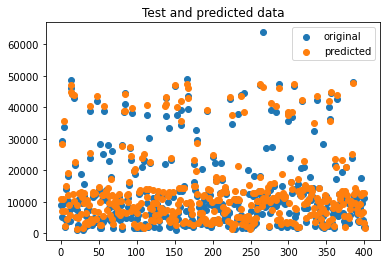

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(alpha=0.01))])

  score     train_set      test_set
0   R^2         86.05         87.12
1   MSE 20,438,964.80 18,889,326.52
2  RMSE      4,520.95      4,346.19
3   MAE      2,538.58      2,424.30

Cross validation score: 85.17%
Time elapsed: 0.006 sec


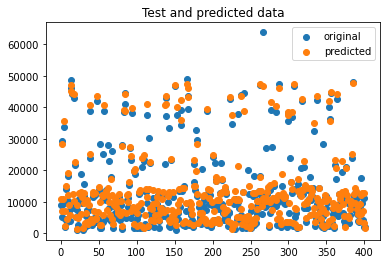

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('xgbregressor',
                 XGBRegressor(alpha=0, base_score=0.5, booster='gblinear',
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              feature_selector='greedy', gamma=None, gpu_id=-1,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.09,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=16, num_parallel_tree=None, predictor=None,
                              random_state=0, reg_alpha=0, reg_lambda=0.001,
                              scale_pos_weight=1, subsample=None, top_k=7,
                              tree_method=None, updater='coord_descent', ...))])

  score     train_set      test_set
0   R^2         86.72         87.31
1   MSE 19,456,763.67 18,612,093.03
2  RMSE      4,410.98      4,314.17
3   MAE      2,433.66      2,375.30

Cross validation score: 85.22%
Time elapsed: 0.079 sec


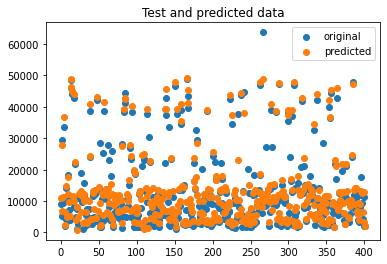

StackingRegressor(estimators=[('en',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('elasticnet',
                                                ElasticNet(alpha=0.01))])),
                              ('ridge', Ridge()),
                              ('xgb',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('polynomialfeatures',
                                                PolynomialFeatures(interaction_only=True)),
                                               ('xgbregressor',
                                                XGBRegressor(alpha=0,
                                                             base_score=0.5,
                                                             booster='gblinear',
                                                             colsampl...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.09,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=16,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=0,
                                                             reg_alpha=0,
                                                             reg_lambda=0.001,
                                                             scale_pos_weight=1,
                                                             subsample=None,
                                                             top_k=7,
                                                             tree_method=None,
                                                             updater='coord_descent', ...))]))])

  score     train_set      test_set
0   R^2         86.53         87.29
1   MSE 19,735,920.53 18,638,965.14
2  RMSE      4,442.51      4,317.29
3   MAE      2,453.28      2,382.37

Cross validation score: 85.25%
Time elapsed: 0.402 sec


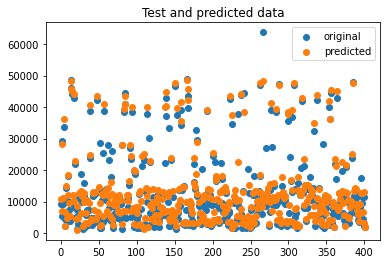

In [18]:
for model in models:
    run_model(model, X_train, y_train, X_test, y_test)

#### Wizuaizacja danych klienta

In [19]:
# wykres charges v. age z uwzglednieniem danych klienta z widget
def visualize_charges(bmi, prediction):
        # dodanie progow oplat
    df['charges_thresholds'] = 0
    # progi:
    IV_opis = '> 30.000'
    III_opis = '15.000 - 30.000'
    III_prog = 30000
    II_prog = 15000
    II_opis = '6.000 - 15.000'
    I_prog = 6000
    I_opis = '< 6.000'

    for index, row in df.iterrows():
        if row['charges'] > III_prog:
            df.loc[index,'charges_thresholds'] = IV_opis
        elif row['charges'] < I_prog:
            df.loc[index,'charges_thresholds'] = I_opis
        elif row['charges'] > I_prog and row['charges'] < II_prog:
            df.loc[index,'charges_thresholds'] = II_opis
        else:
            df.loc[index,'charges_thresholds'] = III_opis
    lista_customer = [[bmi, 
                   values['age_slider'], 
                   prediction]]

    df_customer = pd.DataFrame(lista_customer)
    df_customer.columns = ['bmi_custom', 'age_customer', 'customer_fee']
    # plots
    fig, axes = plt.subplots(1, 2, figsize=(19,11))
    sns.despine()
    for ax in axes.flat:
        sns.despine(left=not ax.get_subplotspec().is_first_col(), ax=ax)
    fig.suptitle('Charges', fontweight='bold',fontsize=28)
    fig.supylabel('charges', fontsize=22)
    ax_1 = sns.scatterplot(ax=axes[0],data=df, x='bmi', y='charges', hue='charges_thresholds',
                   hue_order=['> 30.000', '15.000 - 30.000', '6.000 - 15.000', '< 6.000'],s=30, legend=False,
                   alpha=0.5)
    ax_1.set_title('vs bmi', fontsize=20)
    plt.tight_layout()
    ax_1.set_ylabel(None)
    ax_1.set_xlabel('bmi', fontsize=22)
    ax_1.scatter(x=df_customer['bmi_custom'], y=df_customer['customer_fee'],color='yellow', marker='o',s=200, edgecolors='black', linewidths=2)
    ax_2 = sns.scatterplot(ax=axes[1],data=df, x='age', y='charges', hue='charges_thresholds',
                   hue_order=['> 30.000', '15.000 - 30.000', '6.000 - 15.000', '< 6.000'],s=30,
                   alpha=0.5)
    ax_2.set_title('vs age', fontsize=20)
    ax_2.set_ylabel(None)
    ax_2.set_xlabel('age', fontsize=22)
    ax_2.set(yticklabels=[])  
    ax_2.tick_params(left=False) 
    ax_2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,title='$\\bfThresholds$', title_fontsize=20, fontsize=18)
    ax_2.scatter(x=df_customer['age_customer'], y=df_customer['customer_fee'],color='yellow', marker='o',s=200, edgecolors='black', linewidths=2)

    plt.show()

In [20]:
# dodanie progow opl
df['charges_thresholds'] = 0

# progi:
IV_opis = '> 30.000'
III_opis = '15.000 - 30.000'
III_prog = 30000
II_prog = 15000
II_opis = '6.000 - 15.000'
I_prog = 6000
I_opis = '< 6.000'

for index, row in df.iterrows():
    if row['charges'] > III_prog:
        df.loc[index,'charges_thresholds'] = IV_opis
    elif row['charges'] < I_prog:
        df.loc[index,'charges_thresholds'] = I_opis
    elif row['charges'] > I_prog and row['charges'] < II_prog:
        df.loc[index,'charges_thresholds'] = II_opis
    else:
        df.loc[index,'charges_thresholds'] = III_opis

customer_fee = 20000 
        
# df.groupby('charges_thresholds').mean()
customer_bmi = values['weight_slider'] / (values['height_slider']/100)**2
customer_bmi
# df dla danych klienta
lista_customer = [[customer_bmi, 
                   values['age_slider'], 
                   customer_fee]]

df_customer = pd.DataFrame(lista_customer)
df_customer.columns = ['bmi_custom', 'age_customer', 'customer_fee']
group_1 = df[df['charges'] < I_prog]
group_2 = df[df['charges'] < II_prog]
group_3 = df[df['charges'] <= III_prog]
group_4 = df[df['charges'] > III_prog]

In [205]:
def add_thresholds(df):
    df['charges_thresholds']=0
    IV_opis = '> 30.000'
    III_opis = '15.000 - 30.000'
    III_prog = 30000
    II_prog = 15000
    II_opis = '6.000 - 15.000'
    I_prog = 6000
    I_opis = '< 6.000'

    for index, row in df.iterrows():
        if row['charges'] > III_prog:
            df.loc[index,'charges_thresholds'] = IV_opis
        elif row['charges'] < I_prog:
            df.loc[index,'charges_thresholds'] = I_opis
        elif row['charges'] > I_prog and row['charges'] < II_prog:
            df.loc[index,'charges_thresholds'] = II_opis
        else:
            df.loc[index,'charges_thresholds'] = III_opis 
    threshold=str(df['charges_thresholds'].values[0])
    if threshold==IV_opis:
        group_no=4
    elif threshold==III_opis:
        group_no=3
    elif threshold==II_opis:
        group_no=2
    else:
        group_no=1
    message=(f'Customer is proposed to be included in payment group {group_no} with threshold = {threshold} per year')
    print(message)

In [206]:
def graph1():
    ax_1 = sns.relplot(data=df, x='bmi', y='charges', hue='charges_thresholds',
                   hue_order=['> 30.000', '15.000 - 30.000', '6.000 - 15.000', '< 6.000'],
                   alpha=0.2)
    (ax_1.map(plt.scatter, x=df_customer['bmi_custom'], y=df_customer['customer_fee'], 
           color='yellow', marker='o', edgecolors='black', linewidths=2)
      .tight_layout(w_pad=0))
    plt.title('Charges v. BMI')
    plt.xlabel('Charges')
    plt.ylabel('BMI')
    plt.show()

In [207]:
# wykres charges v. age z uwzglednieniem danych klienta z widget
def graph2():
    ax_2 = sns.relplot(data=df, x='age', y='charges', hue='charges_thresholds',
                   hue_order=['> 30.000', '15.000 - 30.000', '6.000 - 15.000', '< 6.000'],
                   alpha=0.2)
    (ax_2.map(plt.scatter, x=df_customer['age_customer'], y=df_customer['customer_fee'], 
           color='yellow', marker='o', edgecolors='black', linewidths=2)
      .tight_layout(w_pad=0))
    plt.title('Charges v. Age')
    plt.xlabel('Charges')
    plt.ylabel('Age')
    plt.show()

In [208]:
from ipywidgets import widgets
from IPython.display import display, clear_output
#run button
run_button = widgets.Button(description="Predict")



def button_callback(button):
    output.clear_output()
    with output:
        age=values['age_slider']
        bmi=values['weight_slider']/(values['height_slider']/100)**2
        children=values['children_slider']
        smoker_yes=values['smoker_button']
        if values['region_dropdown']=='northwest':
            region_northwest=1
            region_southeast=0
            region_southwest=0
        elif values['region_dropdown']=='southeast':
            region_northwest=0
            region_southeast=1
            region_southwest=0
        elif values['region_dropdown']=='southwest':
            region_northwest=0
            region_southeast=0
            region_southwest=1
        else:
            region_northwest=0
            region_southeast=0
            region_southwest=0
        if bmi>=30:
            obese=1
        else:
            obese=0
        if (bmi>=30) & (smoker_yes==1):
            obese_smoker=1
        else:
            obese_smoker=0
        if values['sex_dropdown']=='male':
            sex_male=1
        else:
            sex_male=0

        values_to_predict= [age, bmi, children, sex_male, smoker_yes, region_northwest, region_southeast,
              region_southwest, obese, obese_smoker]
        columns=['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
           'region_northwest', 'region_southeast', 'region_southwest', 'obese', 'obese_smoker']
        to_predict=pd.DataFrame([values_to_predict],columns=columns)
        prediction = int(xgb_model.predict(to_predict))
        to_predict['charges']=prediction
        print(f'\033[1mPredicted charges for customer: {prediction}\033[0m')
        add_thresholds(to_predict)

        print()
        visualize_charges(bmi,prediction)
run_button.on_click(button_callback)


In [209]:
#widgety_predict
 
def clear_output():
    change_output_button = widgets.Button(description="Change output?")
    the_output = widgets.Output()
    clear_output_widget = widgets.VBox([change_output_button, the_output])
    clear_output_widget.click_count = 0

    def button_clicked(_button):
        clear_output_widget.click_count += 1
        the_output.clear_output()
        with the_output:
            print(f"button clicked {clear_output_widget.click_count} times.")

            
    change_output_button.on_click(button_clicked)

    return clear_output_widget

result = widgets.interactive(widgets_handler,
                 sex_dropdown_val = widget_sex,
                 region_dropdown_val = widget_region,
                 smoker_button_val = widget_smoker,
                 age_slider_val = widget_age,
                 height_slider_val = widget_height,
                 weight_slider_val = widget_weight,
                 children_slider_val = widget_children)
layout = widgets.Layout(width='auto', height='auto', grid_gap='50px')
controls1 = widgets.HBox(result.children[0:3], layout=layout)
controls2 = widgets.HBox(result.children[3:5], layout=layout)
controls3 = widgets.HBox(result.children[5:-1], layout=layout)
output=widgets.Output()
display(widgets.VBox([controls1,
                      controls2,
                      controls3,
                      run_button,
                      output],layout=widgets.Layout(margin = '50px 20px 50px 20px',grid_gap='30px')))